# Running a statistical trial for a machine learning regression model

Imagine you have been given an imaging dataset and you have trained a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) to count the number of cells in the image for a medical-based task. On a held-out test set you observe an average error ±5 cells. In order to be considered reliable enough for clinical use, the algorithm needs to be further validated on a prospective trial. The purpose of a such a trial is to 1) ensure that the algorithm's performance is close to what was observed on a test set, and 2) increase the rigour of assessment through a pre-specified protocol. How should such a statistical trial be conducted and what statistical quantities should be estimated? In this post I outline a two-stage method to conduct a validation study for a regression model. This strategy amounts to answering two questions:

1. What is the upper-bound error the algorithm could have before it is was no longer of practical use (e.g. ±10 cells)? 
2. Conditional on this upper bound, how many samples will be needed in a prospective trial to establish that the error is *at most* a certain size?

In a previous [post](http://www.erikdrysdale.com/threshold_and_power) I discussed how to calibrate a machine learning (ML) model for a binary classification task in the context of a statistical trial. The classical ML pipeline is to train and tune a model on a training and validation set, and then make predictions (only once) on a test set to get an "unbiased" estimate of a specific performance metric.[[^1]] A statistical trial represents a further iteration on the ML pipeline: collecting data prospectively to "confirm" that the model works as well as you expect. For binary classifiers there were two statistical procedures when preparing for a prospective trial: 1) using the test set to establish a conservative threshold for a target performance level (e.g. 90% sensitivity), 2) picking a slightly worse trial goal (e.g. 80% sensitivity) and calculating a sample size necessary based on this spread. The first procedure relied on the statistical properties of the threshold (which is a random variable) for a given fixed hypothesis. The second procedure could be trivially calculated using statistical tests for the difference in two binomial proportions. 

The regression case is more complicated because the desired performance cannot be chosen in advance: the result is what it is. One possibility is to pre-specify a null hypothesis (e.g. R-squared greater than 10%), and only run prospective trials for algorithms that rejected this null. However, such an approach would create a statistical significance [filter](http://www.erikdrysdale.com/winners_curse) that would, conditional on success (i.e. rejection of null), cause the expected test set performance to be biased upwards. Such a bias would lead to algorithms which fail to generalize and underestimate the prospective sample size that will be needed.

I have developed a two-stage testing strategy that avoids the problem of statistical significance filters and relies of classical statistical hypothesis testing paradigms. This approach has several advantages:

1. Model performance will be unbiased
2. Classical statistical techniques can be used to obtain valid inference
3. The upper bound can be chosen with respect to power considerations or the application use case, or both
4. **The analysis applies to any ML algorithm and any performance metric** (conditional on some regularity conditions)

The rest of the post is structured as follows: section (1) provides the statistical framework for a two-stage testing strategy for estimating the mean of a Gaussian, section (2) shows how two common regression performance metrics can be used and approximated by a Gaussian distribution, and section (3) provides an example pipeline of how this framework can be used and statistical simulation results.

[^1]: If the test set is non-representative of the future data generating process then the results of this subsequent analysis will not hold. Dealing with dataset shift is a large topic area that is beyond the scope of this post.

## (1) Two-stage testing approach

Imagine you will have access to two independent datasets, and your goal is to establish an upper-bound on the "true" mean of a Gaussian distribution. In the first stage, a sample is drawn, and the distribution of the sample mean is used to estimate the null hypothesis. In the second stage, a new sample is drawn, and the null from stage 1 is used to calculate a test statistic and a p-value. Assume the data is IID and comes from a normal distribution with a known variance: $X_i \sim N(\mu, \sigma^2)$.

$$
\begin{align*}
&\text{Step 1: Establish null} \\
\hat{\mu}_0 &= \hat\mu_1 + k \sqrt{\sigma^2 / n_1} \\
H_0&: \mu \geq \hat{\mu}_0 \\
H_A&: \mu < \hat{\mu}_0 \\
&\text{Step 2: Test on second sample} \\
s_2 &= \frac{\hat\mu_2 - \hat\mu_0}{\sqrt{\sigma^2 / n_2}} \\
\text{Reject }H_0&: s_2 < \Phi_{s_2}^{-1}(\alpha|H_0) = t_\alpha
\end{align*}
$$

In the first stage, the null is estimated as the point estimate of the sample mean plus $k$ standard deviations above it. As the value of $k$ increases, the power of the second-stage test increases. However, the "information" about the true mean decreases since the bound becomes larger. Consider the distribution of $s_2$, which is the test statistic in the second stage of the procedure:

$$
\begin{align*}
s_2&= \frac{\hat\mu_2-[\hat\mu_1+k\sqrt{\sigma^2/n_1}]}{\sigma^2/n_2} \\
&= z_2 - \sqrt{n_2/n_1}(z_1 + k) \\
z_i &= \frac{\hat\mu_i - \mu}{\sqrt{\sigma^2 / n_i}}
\end{align*}
$$

The unconditional distribution of the statistic can be seen to have a normal distribution:

$$
\begin{align*}
s_2&\sim N\big(-\sqrt{n_2/n_1}\cdot k, 1+n_2/n_1\big)
\end{align*}
$$

For a given $n_2$, as $n_1 \to \infty$, then the probability of rejecting the null, $P(s_2 < t_\alpha)$, approaches $\alpha$ since $s_2 \to N(0,1)$. For a given $n_1$, as $n_2 \to \infty$, then the probability of rejecting the null approaches $\Phi(k)$.[[^2]] However, in order to calculate the type-I and type-II errors of a testing procedure we need to know the distribution of $s_2$ conditional on the status of the null. Such as distribution is more complex:

$$
\begin{align}
s_2 | \{\text{$H_0$ is false}\} &\sim \frac{\hat\mu_2-\hat\mu_0}{\sqrt{\sigma^2/n_2}} \hspace{1mm} \Big|\hspace{1mm} \hat\mu_0 > \mu \nonumber \\
&\sim z_2 - r\cdot z_1^k | z_1^k > 0 \label{eq:dist_cond} \\
z_1^k &= z_1 + k, \hspace{3mm} r = \sqrt{n_2/n_1} \nonumber
\end{align}
$$

The conditional test statistic in \eqref{eq:dist_cond} is equivalent to a weighted sum of a standard normal and a truncated normal distribution. How can we characterize this distribution? The first step is to define a bivariate normal distribution as a function of $z_2\sim N(0,1)$ and $z_1^k~\sim(k,1)$.

$$
\begin{align}
X&= z_2 - r\cdot Y \nonumber \\ 
Y&= z_1^k \nonumber\\
\begin{pmatrix} X \\ Y \end{pmatrix} &\sim \text{MVN}\Bigg[ \begin{pmatrix} -rk \\ k \end{pmatrix}, \begin{pmatrix} 1+r^2 & -r \\ -r & 1 \end{pmatrix} \Bigg] \label{eq:dist_MVN} \\
\rho &= \frac{-r}{\sqrt{1+r^2}} \nonumber
\end{align}
$$

How does this help us? Luckily the distribution of a truncated bivariate normal distribution for one of the variables has been [characterized](https://link.springer.com/article/10.1007/BF02294652) already by *Arnold et. al*. After working out some of the math, the marginal density function of $X$ in \eqref{eq:dist_MVN}, conditional on $Y > 0$ or $Y<0$, can be written as follows:

$$
\begin{align*}
f_X(x) &= \frac{1}{\Phi(s\cdot k)} \cdot \frac{1}{\sqrt{1+r^2}} \cdot \phi\Bigg(\frac{x+rk}{\sqrt{1+r^2}} \Bigg) \cdot \Phi\Bigg(s\cdot \Bigg[ -r\cdot \frac{x+rk}{\sqrt{1+r^2}} + \sqrt{1+r^2}\cdot  k \Bigg] \Bigg) \\
s &= \begin{cases}
+1 &\text{ if } \text{$H_0$ is false, } \hspace{2mm} (Y>0) \\
-1 &\text{ if } \text{$H_0$ is true, }  \hspace{2mm} (Y<0)
\end{cases} \\
f_W(w) &= \frac{1}{\Phi(k)} \cdot \frac{1}{\sigma_W} \cdot \phi(w) \cdot  \Phi(a + b\cdot w), \hspace{3mm} w=\frac{x+rk}{\sqrt{1+r^2}}
\end{align*}
$$

Next, we can use the result from Owen's classic [paper](https://www.tandfonline.com/doi/abs/10.1080/03610918008812164) which shows that that [integral](https://mathoverflow.net/questions/283928/closed-form-solution-for-an-integral-involving-the-p-d-f-and-c-d-f-of-a-n0-1) needed for calculating $F_W$ can be calculated from the CDF of a bivariate normal:

$$
\begin{align*}
F_W(w;s) &= \frac{1}{\Phi(s\cdot k)} \int_{-\infty}^w \frac{1}{\sigma_W} \cdot \phi(u) \cdot  \Phi(a(s) + b(s)\cdot u) du \\
    &= \frac{1}{\Phi(s\cdot k)}  \text{BVN}\Big( X_1 \leq \frac{a(s)}{\sqrt{1+b(s)^2}}, X_2 \leq w, \rho=-b(s)/\sqrt{1+b(s)^2} \Big) \\
F_X(x;s) &= F_W\big((x+rk) / \sqrt{1+r^2};s\big) \label{eq:cdf_X}
\end{align*}
$$

The first code block below shows how to calculate the CDF of \eqref{eq:dist_cond} using \eqref{eq:cdf_X}. Simulations are run to demonstrate the accuracy of this approach.

[^2]: Throughout this post $\Phi$ and $\phi$ denote the standard normal CDF and PDF, respectively.

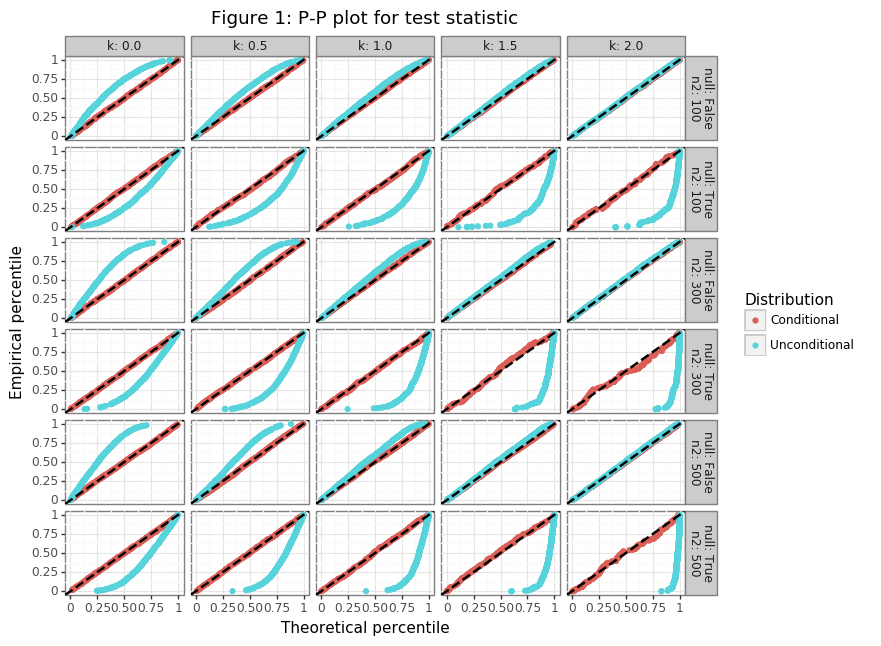

<ggplot: (8778543454497)>

In [1]:
from time import time
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import pandas as pd
import plotnine
from plotnine import *
from scipy.optimize import minimize_scalar

class cond_dist():
    def __init__(self, k, n1, n2, null=False):
        self.s = +1
        if null is True:
            self.s = -1
        self.k, self.n1, self.n2 = k, n1, n2
        self.r = np.sqrt(n2 / n1)
    
    def cdf_w(self, w):
        a = np.sqrt(1+self.r**2) * self.k * self.s
        b = -self.r * self.s
        rho = -b/np.sqrt(1+b**2)
        Sigma = np.array([[1,rho],[rho,1]])
        dist_MVN = MVN(mean=np.repeat(0,2),cov=Sigma)
        x1 = a / np.sqrt(1+b**2)
        if isinstance(w, float):
            X = [x1, w]
        else:
            X = np.c_[np.repeat(x1,len(w)), w]
        pval = dist_MVN.cdf(X)
        return pval
    
    def cdf_x(self, x):
        const = 1 / norm.cdf(self.s * self.k)
        w = (x + self.r * self.k) / np.sqrt(1+self.r**2)
        pval = self.cdf_w(w) * const
        return pval
    
    def quantile(self, p):
        res = minimize_scalar(fun=lambda x: (self.cdf_x(x)-p)**2, method='brent').x
        return res
    
seed = 1234
n1 = 100
sig2 = 2
mu = 3
nsim = 5000

n2_seq = [100, 300, 500]
k_seq = list(np.arange(0,2.5,0.5))

np.random.seed(seed)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        # Calculate the p-values
        pval_h0false = cond_dist(k=k, n1=n1, n2=n2, null=False).cdf_x(s2)
        pval_h0true = cond_dist(k=k, n1=n1, n2=n2, null=True).cdf_x(s2)
        pval_uncond = norm(loc=-np.sqrt(n2/n1)*k,scale=np.sqrt(1+n2/n1)).cdf(s2)
        tmp = pd.DataFrame({'s2':s2,'mu0':null_mu,'n2':n2,'k':k,
                            'h0_false':pval_h0false, 'h0_true':pval_h0true,'pval_uncond':pval_uncond})
        holder.append(tmp)
        del tmp
df_res = pd.concat(holder).assign(null=lambda x: np.where(x.mu0 > mu, False, True))
cn_gg = ['null','n2','k']
df_res = df_res.sort_values(cn_gg+['s2']).reset_index(None,True)
df_res = df_res.assign(idx=df_res.groupby(cn_gg).cumcount())
df_res.idx = df_res.groupby(cn_gg).apply(lambda x: x.idx/x.idx.max()).values
# Compare the conditional distribution
df_res = df_res.assign(pval_cond=lambda x: np.where(x.null==False,x.h0_false,x.h0_true))
df_res_long = df_res.melt(cn_gg+['idx'],['pval_cond','pval_uncond'],'tt')

# Make a pp-plot
tmp = df_res_long.groupby(cn_gg+['tt']).sample(n=250, random_state=seed,replace=True)
plotnine.options.figure_size = (8, 7)
gg_pp = (ggplot(tmp, aes(x='value',y='idx',color='tt')) + theme_bw() + 
         geom_point() + labs(x='Theoretical percentile',y='Empirical percentile') + 
         ggtitle('Figure 1: P-P plot for test statistic') + 
         facet_grid('n2+null~k',labeller=label_both) + 
         scale_color_discrete(name='Distribution',labels=['Conditional','Unconditional']) + 
         geom_abline(slope=1,intercept=0,linetype='--',color='black',size=1))
gg_pp

Figure 1 shows that the CDF for the conditional distribution in \eqref{eq:cdf_X} accurately captures the distribution of the test statistic when the null is both false and true. When the null is false ($z_1^k > 0)$, for larger values of $k$, the unconditonal distribution of $s_2$ is a close approximation. This result makes sense since when the null hypothesis is set many standard deviations above the point estimate, the null will be false for almost all realizations so the conditioning event excludes very few realizations. 

In classical statistics we pick a critical value to reject the null such that when the null is true, then rejection event happens at most $\alpha$ percent of the time. We can use \eqref{eq:cdf_X} to find the $\alpha-$quantile of the distribution when the null is true so that we reject it at most $a$-percent of the time:

$$
\begin{align}
F^{-1}_W(\alpha;-1) &= \sup_w: \{ F_W(w;-1)\leq \alpha \} \label{eq:quantile} \\
&= t_\alpha \nonumber
\end{align}
$$

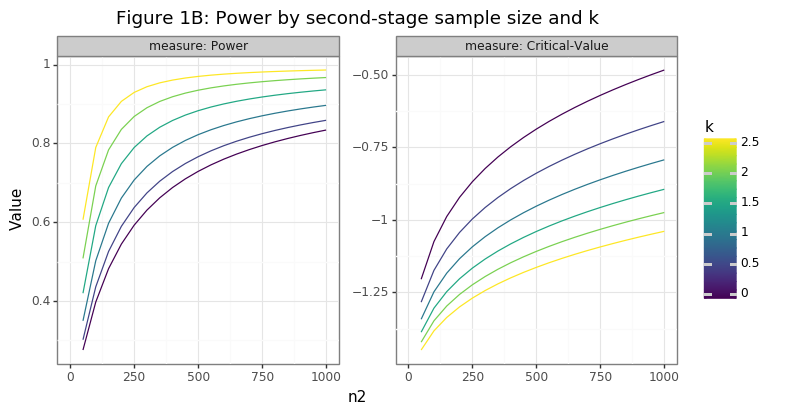

<ggplot: (8778540787169)>

In [2]:
np.random.seed(seed)
# Calculate power for a range of n2's/k's
alpha = 0.05
n2_seq = np.arange(50,1001, 50)
k_seq = np.arange(0.0, 2.51, 0.50)
holder = []
for k in k_seq:
    for n2 in n2_seq:
        dd_true = cond_dist(k=k, n1=n1, n2=n2, null=True)
        dd_false = cond_dist(k=k, n1=n1, n2=n2, null=False)
        crit = dd_true.quantile(alpha)
        power_theory = dd_false.cdf_x(crit)
        # --- simulation --- #
        c = k * np.sqrt(sig2/n1)
        # Draw samples for two-stages
        x1 = mu + np.sqrt(sig2)*np.random.randn(n1, nsim)
        x2 = mu + np.sqrt(sig2)*np.random.randn(n2, nsim)
        xbar1, xbar2 = x1.mean(0), x2.mean(0)
        null_mu = xbar1 + c
        s2 = (xbar2 - null_mu)/np.sqrt(sig2/n2)
        power_emp = np.mean(s2[null_mu > mu] < crit)
        type1_emp = np.mean(s2[null_mu < mu] < crit)
        # ------------------ #
        tmp = pd.Series({'k':k,'n2':n2,'Critical-Value':crit,'Power':power_theory,
                         'emp_power':power_emp, 'emp_type1':type1_emp})
        holder.append(tmp)
        del tmp
df_power = pd.concat(holder,1).T
df_power_long = df_power.melt(['k','n2'],['Critical-Value','Power'],'measure')
df_power_long.measure = pd.Categorical(df_power_long.measure,['Power','Critical-Value'])

plotnine.options.figure_size = (8, 4)
gg_power = (ggplot(df_power_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Value') + 
            facet_wrap('~measure',labeller=label_both,scales='free_y') + 
            ggtitle('Figure 1B: Power by second-stage sample size and k') + 
            theme(subplots_adjust={'wspace': 0.20}) + 
            scale_x_continuous(limits=[0,1001]))
gg_power

Figure 1B reveals that as the second-stage sample size ($n_2$) or the value of $k$ grows, the power of the test increases. Higher values of $k$ ensures that the expected value between $\hat\mu_2 - \hat\mu_0$ becomes increasingly negative, raising the probability of rejection. A higher second-stage sample size decreases the variation of $\hat\mu_2$, ensuring that the average negative difference is more consistently around the expectation, once again increasing the probability of rejection. 

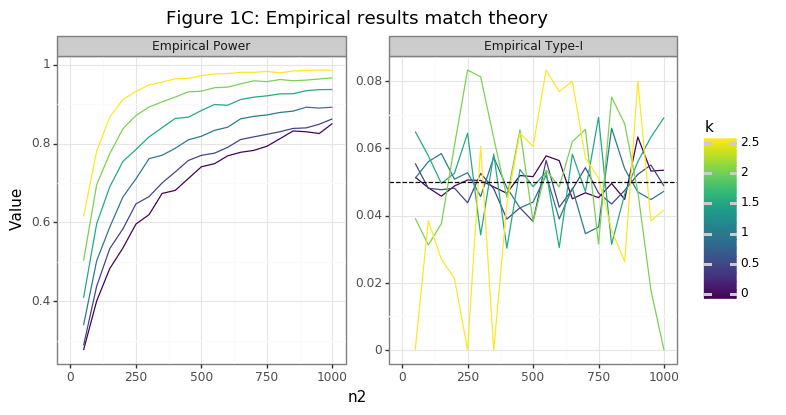

<ggplot: (8778540759133)>

In [3]:
df_emp_long = df_power.melt(['k','n2'],['emp_power','emp_type1'],'tt')
df_emp_long.tt = df_emp_long.tt.map({'emp_power':'Empirical Power','emp_type1':'Empirical Type-I'})
tmp = pd.DataFrame({'tt':'Empirical Type-I', 'vv':0.05},index=[0])
plotnine.options.figure_size = (8, 4)
gg_emp = (ggplot(df_emp_long,aes(x='n2',y='value',color='k',group='k')) + theme_bw() + 
            geom_line() + labs(x='n2',y='Value') + facet_wrap('~tt',scales='free_y') + 
            ggtitle('Figure 1C: Empirical results match theory') + 
            theme(subplots_adjust={'wspace': 0.15}) + 
            scale_x_continuous(limits=[0,1001]) + 
            geom_hline(aes(yintercept='vv'),data=tmp,inherit_aes=False,linetype='--'))
gg_emp

Figure 1C shows that the empirical power curves line up with the theoretical expectation, and that the type-I error rates average to the expected level: 5%. Note that the empirical type-I error rates are not exactly 5% by random chance alone. For a sufficiently large number of simulation draws, the estimates will converge to the 5% line.

## (2) Regression statistic inference example

This section will show how to apply the principle of two-stage testing to example regression performance metrics: mean absolute error (MAE) and mean square error (MSE). In addition to being common metrics, these statistics also have known distributional properties when a linear regression model is used with Gaussian data. Hence, the statistical simulations can be benchmarked against a ground truth. However, in practice any regression statistic whose density function is reasonably smooth, and any regression model can be used. To repeat, the simple linear model and choice of statistics is only for convenience and does not signify a loss of generality to any other regression instance. Formally we are interested in the risk of the MAE & MSE loss functions:

$$
\begin{align*}
R_{MAE}(\theta) = E_{y\sim g(x)}[\text{MAE}(y,f_\theta(x)] \\
R_{MSE}(\theta) = E_{y\sim g(x)}[\text{MSE}(y,f_\theta(x)]
\end{align*}
$$

Where $y$ and $x$ are the response and the feature set, respectively, and $f_\theta(x)$ is a linear regression model indexed by its coefficient vector: $\theta$. Assume that the joint distribution is Gaussian:

$$
\begin{align*}
y &= x^T \theta^0 + u \\
u_i&\sim N(0,\sigma^2_u), \hspace{3mm} x \sim \text{MVN}(0,I) \\
e &= y - f_\theta(x) \\
&= x^T(\theta^0 - \theta) + u \\
&\sim N(0, \sigma^2_u + \| \theta^0 - \theta \|^2_2 )
\end{align*}
$$

The errors of such a model have a Gaussian distribution, with a variance equal to some irreducible error ($\sigma^2_u$) and the L2-norm of the coefficient error: $\sum_j (\theta_j^0 - \theta_j^2)$. The risk for the MSE or MAE can be easily calculated since the error, $e$, has a known distribution:

$$
\begin{align}
R_{MSE}(\theta) &= E(e^2) = \sigma^2_u + \| \theta^0 - \theta \|^2_2 \label{eq:risk_mse} \\
R_{MAE}(\theta) &= E( |e| ) = \sqrt{\sigma^2_u + \| \theta^0 - \theta \|^2_2}\cdot\sqrt{2/\pi} \label{eq:risk_mae}
\end{align}
$$

Where the risk for the MAE comes from the [half-normal](https://en.wikipedia.org/wiki/Half-normal_distribution) distribution. The empirical estimate of the MAE and MSE is simply their sample average:

$$
\begin{align*}
\hat{\text{MSE}}(\theta) &= n^{-1} \sum_{i=1}^n [y_i - f_\theta(x_i)]^2 \\
\hat{\text{MAE}}(\theta) &= n^{-1} \sum_{i=1}^n |y_i - f_\theta(x_i)|
\end{align*}
$$

On a test set with a sufficiently large $n$, $\hat{\text{MSE}}(\theta) \to R_{MSE}(\theta)$. However, for fininte sample it is clear that $\hat{\text{MSE}}(\theta)$ is a random variable whose first moment will be centered around the risk.

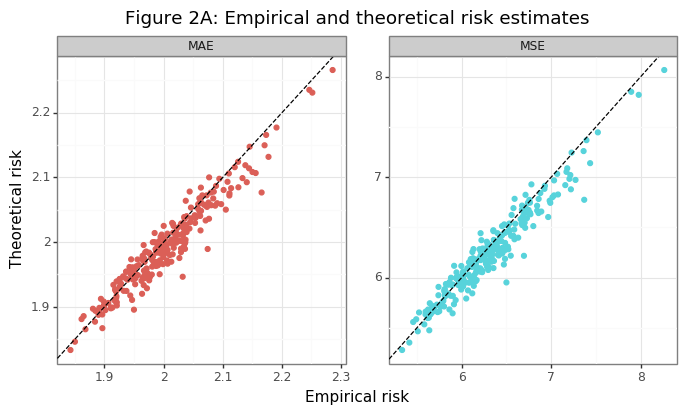

<ggplot: (8778540556245)>

In [4]:
from sklearn.linear_model import LinearRegression
from arch.bootstrap import IIDBootstrap
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

def dgp_yX(n,p,t0=1,sig2=1,theta0=None):
    X = np.random.randn(n,p)
    if theta0 is None:
        theta0 = np.repeat(t0,p) * np.sign(np.random.rand(p)-0.5)
    eta = X.dot(theta0)
    error = np.sqrt(sig2)*np.random.randn(n)
    y = eta + error
    return y, X, theta0
    
np.random.seed(seed)
n, p, t0 = 100, 20, 0.5
sig2 = t0**2*p
nsim = 250
holder = []
for ii in range(nsim):
    y, X, theta0 = dgp_yX(n, p, t0=t0, sig2=sig2)
    mdl = LinearRegression(fit_intercept=True).fit(y=y,X=X)
    l2_error = np.sum((theta0 - mdl.coef_)**2)
    ytest, Xtest, _ = dgp_yX(100*n, p, theta0=theta0, sig2=sig2)
    eta_test = mdl.predict(Xtest)
    # Calculate theoretical R(MSE), R(MAE)
    risk_mse, risk_mae = sig2 + l2_error, np.sqrt((sig2 + l2_error)*2/np.pi)
    hat_mse, hat_mae = MSE(ytest, eta_test), MAE(ytest, eta_test)
    tmp = pd.DataFrame({'risk_mse':risk_mse, 'hat_mse':hat_mse, 'risk_mae':risk_mae, 'hat_mae':hat_mae}, index=[ii])
    holder.append(tmp)
    del tmp
df_risk = pd.concat(holder).rename_axis('idx').reset_index().melt('idx',None,'tmp')
df_risk = df_risk.assign(tt=lambda x: x.tmp.str.split('_',2,True).iloc[:,0],
                         metric=lambda x: x.tmp.str.split('_',2,True).iloc[:,1]).drop(columns=['tmp'])
df_risk = df_risk.pivot_table('value',['idx','metric'],'tt').reset_index()

plotnine.options.figure_size = (8, 4)
gg_risk = (ggplot(df_risk,aes(x='hat',y='risk',color='metric')) + theme_bw() + 
           geom_point() + labs(x='Empirical risk',y='Theoretical risk') + 
           facet_wrap('~metric',labeller=labeller(metric={'mae':'MAE','mse':'MSE'}),scales='free') + 
           theme(subplots_adjust={'wspace': 0.15}) + guides(color=False) + 
           ggtitle('Figure 2A: Empirical and theoretical risk estimates') + 
           geom_abline(slope=1,intercept=0,linetype='--'))
gg_risk

Figure 2A confirms that the empirical risk estimates are closely aligned with their theoretical counterparts. Once again, with a sufficient sample size, the scatter plot would show no variation outside the line going through the origin. In section (1), knowledge of the population standard deviation of the statistic ($\sigma$) was needed in order to calculate the test statistic ($s_2$). Because this quantity is unknown, the [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) can be used to estimate the variance of the performance metric of interest (e.g. MSE & MAE). If $\hat\sigma_{BS}$ is the empirical standard deviation of the bootstrap, then the population standard deviation can be estimated by multiplying it by the number of samples $n$. 

In the simulation below, the accuracy of the bootstrap standard deviation will be compared to the true population standard deviation for the MSE. I am using the MSE rather than the MAE because the former can be characterized by a chi-square distribution:

$$
\begin{align*}
\frac{1}{\sqrt{\sigma^2 + \|\theta_0 - \theta \|_2^2}}\sum_{i=1}^n e_i^2 &\sim \chi^2_n  \\
Var(\chi^2) &= 2n \\
Var(\hat{\text{MSE}}(\theta)) &= \frac{\sigma^2_{MSE}}{n} = \frac{2[\sigma_u^2+\|\theta_0 - \theta \|_2^2]^2}{n}
\end{align*}
$$

The quality of the bootstrapped variance can be compared to its true second moment (that is unknown in practice):

$$
\begin{align}
\sigma^2_{MSE} &\approx n\cdot \hat\sigma^2_{BS} \label{eq:sig2_bs}
\end{align}
$$

Figure 2B below shows that the bootstrapped variance is almost an unbiased estimator of the true variance. 

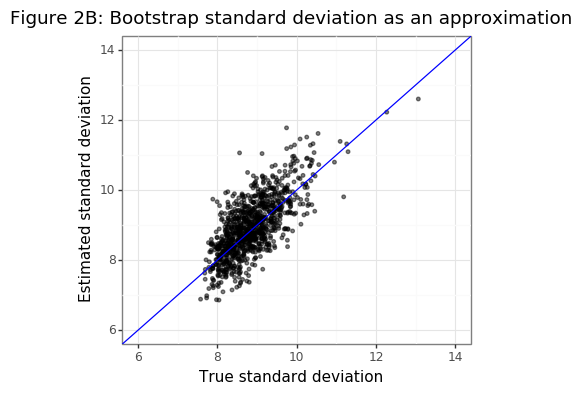

<ggplot: (8778540489077)>

In [5]:
n_bs = 1000
nsim = 1000
np.random.seed(seed)
ntrain = 100
ntest = 1000

holder = np.zeros([nsim,2])
for ii in range(nsim):
    y, X, theta0 = dgp_yX(ntrain, p, t0=t0, sig2=sig2)
    mdl = LinearRegression(fit_intercept=True).fit(y=y,X=X)
    l2_error = np.sum((theta0 - mdl.coef_)**2)
    sig2e = l2_error + sig2
    ytest, Xtest, _ = dgp_yX(ntest, p, theta0=theta0, sig2=sig2)
    eta_test = mdl.predict(Xtest)
    eta_boot = pd.Series(eta_test).sample(ntest*n_bs,replace=True)
    y_boot = ytest[eta_boot.index].reshape([ntest,n_bs])
    eta_boot = eta_boot.values.reshape([ntest,n_bs])
    res_boot = y_boot - eta_boot
    mse_boot = MSE(y_boot, eta_boot,multioutput='raw_values')
    sig2_mse = mse_boot.var()*len(ytest)
    sig2_gt = 2*sig2e**2
    holder[ii] = [sig2_mse, sig2_gt]
dat_sig2 = pd.DataFrame(holder,columns=['hat','gt'])
dat_sig2 = np.sqrt(dat_sig2)

xx, xm = np.ceil(dat_sig2.max().max()), np.floor(dat_sig2.min().min())
plotnine.options.figure_size = (4.5, 4)
gg_sig2 = (ggplot(dat_sig2, aes(x='gt',y='hat')) + theme_bw() + 
           geom_point(alpha=0.5,size=1) + 
           labs(y='Estimated standard deviation',x='True standard deviation') + 
           ggtitle('Figure 2B: Bootstrap standard deviation as an approximation') + 
           geom_abline(slope=1,intercept=0,color='blue') + 
           scale_x_continuous(limits=[xm, xx]) + scale_y_continuous(limits=[xm, xx]))
gg_sig2

## (3) Applied example

At this point we are ready to run a simulation for the MSE & MAE by modifying the procedure outlined in section (1). Instead of estimating the true mean of the Gaussian, the risk of a linear regression model's MSE & MAE will be estimated. The pipeline is as follows:

1. Learn $f_\theta$ on an independent training dataset
2. Calculate MSE & MAE on an independent test set
3. Use the test set to obtain the bootstrap variance of the MSE or MAE: $\hat\sigma^2_{1,BS}$
4. Get an upper-estimate of performance for the null: $\hat{\text{MSE}}_0 = \hat{\text{MSE}}_1 + k \cdot \hat\sigma_{1,BS}$
5. Set the null hypothesis: $H_0: \text{MSE} \geq \hat{\text{MSE}}_0$
6. Find the sample size needed to obtain 80% power and its associated critical value $t_\alpha$ using \eqref{eq:quantile}
7. Estimate model performance on the prospective test set
8. Reject the null if $(\hat{\text{MSE}}_2-\hat{\text{MSE}}_0)/\hat\sigma_{2,BS} < t_\alpha$

In the code block below I am using a [studentized bootstrap](https://www.textbook.ds100.org/ch/18/hyp_studentized.html) to estimate the standard error on both the testing and prospective validation sets. A one-sided confidence interval (CI) of $k \cdot \hat\sigma_{BS}$ is an approximation on the CI at the $\Phi(k)$ level: $z_{\Phi(-k)}\cdot \sqrt{\sigma^2 / n}$. Since the estimate of $\hat\sigma_{BS}$ can be biased downwards for smaller sample sizes and skewed distributions, the studentized bootstrap can "correct" for this. Specifically, the bootstrapped statistic is mapped to a t-score:

$$
\begin{align*}
t^*_b = \frac{\hat{\text{MSE}^*_b} - \hat{\text{MSE}}}{\hat\sigma{_b^*}}
\end{align*}
$$

This approach requires re-bootstrapping a given bootstrapped sample and estimating its standard error $\hat\sigma_b^*$. Though this is computationally intensive, it helps give close to exact nominal coverage levels, and, as I show, can be easily vectorized with the `sample` attribute in `pandas` classes and using 3-D arrays in `numpy`. The upper bound of the interval is: $\hat{\text{MSE}} - q_{\alpha} \hat\sigma_{BS}$, where $q_\alpha$ is the empirical quantile of the $t^*_b$ distribution. For example if $k=1.5$, but $q_{\alpha}=-1.6$, then the standard errors are "too small", so we can adjust by rescaling $\hat\sigma_{BS} \gets \hat\sigma_{BS}\cdot (-q_{\alpha}/k)$. The simulations below will target a sample size needed to obtain 80% power, a type-I error rate of 5%, a $k$ of 1.5, and use a training and test set size of 150. The `power_find` function estimates that 399 samples will be needed in the prospective dataset to reject the null at these rates. 

Not running


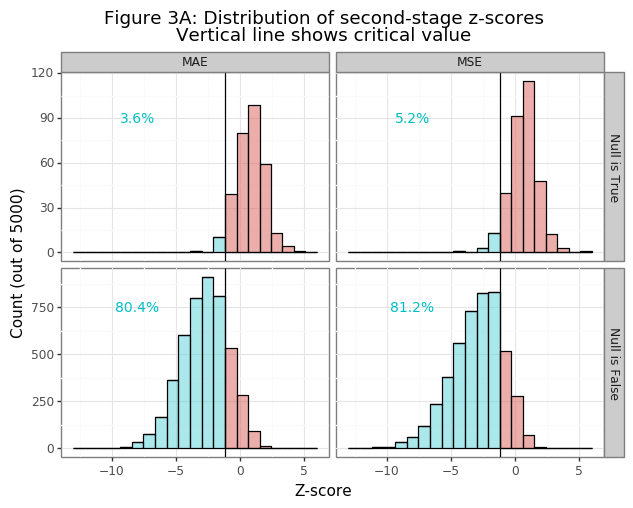

<ggplot: (8778540461741)>

In [6]:
def boot_mse_mae(eta, resp, k, n_bs=1000, n_student=250):
    nn = len(eta)
    mse_hat, mae_hat = MSE(resp, eta), MAE(resp, eta)
    eta_boot = pd.Series(eta).sample(nn*n_bs,replace=True)
    y_boot = pd.DataFrame(resp[eta_boot.index].reshape([nn,n_bs]))
    eta_boot = pd.DataFrame(eta_boot.values.reshape([nn,n_bs]))
    mse_boot = MSE(y_boot, eta_boot, multioutput='raw_values')
    mae_boot = MAE(y_boot, eta_boot, multioutput='raw_values')
    # Run studentized bootstrap for adjustment
    # Recall in the studentized bootstrap the 1-a quantile is used for the lowerbound and the a-quantile for the upper
    tmp1 = eta_boot.sample(frac=n_student,replace=True,axis=0)
    tmp2 = y_boot.iloc[tmp1.index]
    tmp1 = tmp1.values.reshape([n_student]+list(eta_boot.shape))
    tmp2 = tmp2.values.reshape([n_student]+list(y_boot.shape))
    sig_student_mse = np.mean((tmp2 - tmp1)**2,axis=1).std(0)
    sig_student_mae = np.mean(np.abs(tmp2 - tmp1),axis=1).std(0)
    t_mse = (mse_boot - mse_hat)/sig_student_mse
    t_mae = (mae_boot - mae_hat)/sig_student_mae
    k_adjust_mse = -np.quantile(t_mse,norm.cdf(-k))
    k_adjust_mae = -np.quantile(t_mae,norm.cdf(-k))
    # Get standard error estimates
    sig2_mse_n, sig2_mae_n = mse_boot.var(), mae_boot.var()
    # Scale by studentized-t factor
    sig2_mse_n, sig2_mae_n = sig2_mse_n*(k_adjust_mse/k)**2, sig2_mae_n*(k_adjust_mae/k)**2
    return sig2_mse_n, sig2_mae_n, k_adjust_mse, k_adjust_mae

def power_est(n2, k, n1, alpha):
    dist_true = cond_dist(k=k, n1=n1, n2=n2, null=True)
    dist_false = cond_dist(k=k, n1=n1, n2=n2, null=False)
    crit_value = dist_true.quantile(alpha)
    power = dist_false.cdf_x(crit_value)
    return power

def power_find(pp, k, n1, alpha):
    n2 = minimize_scalar(fun=lambda x: (power_est(x, k, n1, alpha)-pp)**2,method='brent').x
    return n2


ntrain, ntest = 150, 150
p, t0 = 20, 0.5
sig2 = t0**2*p / 2
nsim = 5000
k = 1.5
n_bs = 1000
n_student = 250
alpha = 0.05
power = 0.8

# --------------------------------- #
# (6) Find sample size needed for 80% power and critical value
nprosp = int(np.ceil(power_find(power, k=k, n1=ntest, alpha=alpha)))
# Critical value for prospective set
dist_prosp_true = cond_dist(k=k, n1=ntest, n2=nprosp, null=True)
crit_prosp = dist_prosp_true.quantile(alpha)

import os
if os.path.exists('df_sim.csv'):
    print('Not running')
else:
    np.random.seed(seed)

    stime = time()
    holder = []
    for ii in range(nsim):
        if (ii + 1) % 25 == 0:
            nsec, nleft = time() - stime, nsim - (ii+1)
            rate = (ii+1) / nsec
            tleft = nleft / rate
            print('Iteration (%i and %i), ETA: %i seconds' % (ii+1, nsim, tleft))
        # --------------------------------- #
        # (1) Learn f_theta on training set
        y, X, theta0 = dgp_yX(ntrain, p, t0=t0, sig2=sig2)
        mdl = LinearRegression(fit_intercept=True).fit(y=y,X=X)

        # --------------------------------- #
        # (2) Calculate the MSE and MAE on the test set
        ytest, Xtest, _ = dgp_yX(ntest, p, theta0=theta0, sig2=sig2)
        eta_test = mdl.predict(Xtest)
        mse_point, mae_point = MSE(ytest, eta_test), MAE(ytest, eta_test)    

        # --------------------------------- #
        # (3) & (4) Calculate bootstrap variance and the population variance
        sig2_mse_n, sig2_mae_n, k_mse, k_mae = boot_mse_mae(eta=eta_test, resp=ytest, k=k, n_bs=n_bs, n_student=n_student)
        sig2_mse, sig2_mae = sig2_mse_n * ntest, sig2_mae_n * ntest # Population level estimate

        # --------------------------------- #
        # (5) Set upper bound on null
        mse_null = mse_point + k*np.sqrt(sig2_mse_n)
        mae_null = mae_point + k*np.sqrt(sig2_mae_n)
        del mse_point, mae_point

        # --------------------------------- #
        # (7) Generate prospective test set
        yprosp, Xprosp, _ = dgp_yX(nprosp, p, theta0=theta0, sig2=sig2)

        # --------------------------------- #
        # (8) Run inference using studentized bootstrap
        eta_prosp = mdl.predict(Xprosp)
        mse_prosp, mae_prosp = MSE(yprosp, eta_prosp), MAE(yprosp, eta_prosp)
        sig2_mse_n_prosp, sig2_mae_n_prosp, k_mse_prosp, k_mae_prosp = boot_mse_mae(eta=eta_prosp, resp=yprosp, 
                                                                                    k=k, n_bs=n_bs, n_student=n_student)
        z_mse, z_mae = (mse_prosp - mse_null) / np.sqrt(sig2_mse_n_prosp), (mae_prosp - mae_null) / np.sqrt(sig2_mae_n_prosp)
        #print('Z-score for MSE: %0.2f, MAE: %0.2f' % (z_mse, z_mae))

        # These are statistical quantities known only to the "simulator"
        l2_error = np.sum((theta0 - mdl.coef_)**2)
        mse_gt = l2_error + sig2
        mae_gt = np.sqrt(mse_gt * 2 / np.pi)
        sig2_mse_gt = 2*(l2_error + sig2)**2

        tmp = pd.DataFrame({'mse_gt':mse_gt, 'mse_null':mse_null, 'mae_gt':mae_gt, 'mae_null':mae_null,
                            'k_mse':k_mse, 'k_mae':k_mae, 'k_mse_prosp':k_mse_prosp, 'k_mae_prosp':k_mae_prosp,
                            'z_mse':z_mse, 'z_mae':z_mae,'crit':crit_prosp, 'nprosp':nprosp,
                            'sig2_prosp':sig2_mse_n_prosp*nprosp, 'sig2_test':sig2_mse_n*ntest,'sig2_gt':sig2_mse_gt},
                           index=[ii])
        holder.append(tmp)
    df_sim = pd.concat(holder).rename_axis('idx').reset_index()
    df_sim.to_csv('df_sim.csv',index=False)
# Combine results
df_sim = pd.read_csv('df_sim.csv')
dat_coverage = df_sim.melt('idx',['mse_gt','mse_null','mae_gt','mae_null'],'tmp')
dat_coverage = dat_coverage.assign(metric=lambda x: x.tmp.str.split('_',2,True).iloc[:,0],
              tt=lambda x: x.tmp.str.split('_',2,True).iloc[:,1]).drop(columns=['tmp'])
dat_coverage = dat_coverage.pivot_table('value',['idx','metric'],'tt').reset_index()
dat_coverage = dat_coverage.assign(null_is_false=lambda x: x['null'] > x['gt'])
dat_power = df_sim.melt(['idx','crit'],['z_mse','z_mae'],'metric')
dat_power = dat_power.assign(reject=lambda x: x.value < x.crit, metric=lambda x: x.metric.str.replace('z_',''))
dat_power = dat_power.merge(dat_coverage[['idx','metric','null_is_false']],'left',['idx','metric'])

plotnine.options.figure_size = (7, 5)
brks = list(np.concatenate((np.linspace(-13,crit_prosp,14),np.linspace(crit_prosp,6,9)[1:])))
dat_txt = dat_power.groupby(['metric','null_is_false']).reject.mean().reset_index()
dat_txt = dat_txt.assign(lbls=lambda x: (x.reject*100).map('{:,.1f}%'.format))
dat_txt = dat_txt.assign(x=lambda x: np.where(x.null_is_false==True,-8, -8),
                         y=lambda x: np.where(x.null_is_false==True,750, 90))

di_metric = {'mse':'MSE', 'mae':'MAE'}
di_null = {'False':'Null is True', 'True':'Null is False'}
gg_zdist = (ggplot(dat_power, aes(x='value',fill='reject')) + theme_bw() + 
            geom_histogram(alpha=0.5,color='black',breaks=brks) + 
            facet_grid('null_is_false~metric',scales='free',
                       labeller=labeller(metric=di_metric, null_is_false=di_null)) + 
            labs(x='Z-score', y='Count (out of 5000)') + guides(fill=False,color=False) + 
            ggtitle('Figure 3A: Distribution of second-stage z-scores\nVertical line shows critical value') + 
            geom_vline(xintercept=crit_prosp,color='black') + 
            geom_text(aes(x='x',y='y',label='lbls'),color="#00BFC4",data=dat_txt,size=10,inherit_aes=False))
gg_zdist

Figure 3A shows that the two-stage approach is extremely accurate! The simulated power frequency is between 80-81% and the type-I error between 3-5%, just as was expected. 

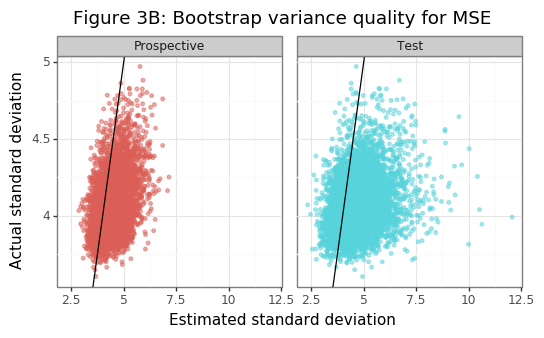

<ggplot: (8778540680745)>


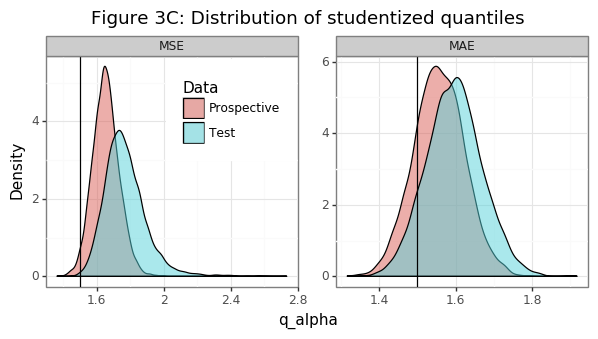

<ggplot: (8778542932393)>


In [7]:
dat_sig2 = df_sim.melt(['idx','sig2_gt'],['sig2_prosp','sig2_test'],'msr').assign(msr=lambda x: x.msr.str.replace('sig2_',''))
di_msr = {'prosp':'Prospective', 'test':'Test', 'gt':'Ground-Truth'}

plotnine.options.figure_size = (6, 3)
gg_sig2 = (ggplot(dat_sig2,aes(x='np.sqrt(value)',y='np.sqrt(sig2_gt)',color='msr')) + theme_bw() + 
           geom_point(size=1,alpha=0.5) + geom_abline(slope=1,intercept=0) + 
           facet_wrap('~msr',labeller=labeller(msr=di_msr)) + 
           labs(x='Estimated standard deviation',y='Actual standard deviation') + 
           ggtitle('Figure 3B: Bootstrap variance quality for MSE') + 
           guides(color=False) + theme(panel_spacing_x=0.15))
print(gg_sig2)

dat_k = df_sim.melt('idx',['k_mse','k_mae','k_mse_prosp','k_mae_prosp'],'tmp').assign(tmp=lambda x: x.tmp.str.replace('k_',''))
dat_k = dat_k.assign(metric=lambda x: np.where(x.tmp.str.contains('mse'),'mse','mae'),
             dset=lambda x: np.where(x.tmp.str.contains('prosp'),'prosp','test')).drop(columns='tmp')
dat_k = dat_k.assign(metric=lambda x: pd.Categorical(x.metric,['mse','mae']))

plotnine.options.figure_size = (7, 3)
gg_k = (ggplot(dat_k,aes(x='value',fill='dset')) + theme_bw() + 
        geom_density(alpha=0.5) + geom_vline(xintercept=k) + 
        facet_wrap('~metric',scales='free',labeller=labeller(metric={'mse':'MSE','mae':'MAE'})) + 
        scale_fill_discrete(name='Data',labels=['Prospective','Test']) + 
        theme(subplots_adjust={'wspace': 0.15},legend_position=(0.39,0.70)) + 
        labs(x='q_alpha',y='Density') + ggtitle('Figure 3C: Distribution of studentized quantiles'))
print(gg_k)

Figure 3B shows that the estimate of the population variance for the MSE is reasonably close to the one obtained from the studentized bootstrap. The variance tends to be overestimated slightly, and Figure 3C explains shows that this is the case because the (negative) $\alpha$ quantile of the studentized bootstrapped statistics tends to be larger than the target of $k=1.5$. In other words, the bootstrap-standard error is usually adjusted upwards. Though not shown here, using a vanilla bootstrap approach will cause the type-II errors and proportion of true nulls to be slightly too large. In fact the empirical coverage of the null, after the studentized adjustment, is basically spot on. For a properly estimated variance, the null hypothesis should be true/false $\Phi(-k)$/$\Phi(k)$ percent of the time.

In [8]:
print(np.round(dat_coverage.groupby(['metric']).null_is_false.mean().reset_index().assign(expectation=[norm.cdf(k),norm.cdf(k)]),3))

  metric  null_is_false  expectation
0    mae          0.939        0.933
1    mse          0.935        0.933


## (4) Conclusion

This post has shown how to construct a prospective trial to validate any ML regression model for any performance metric of interest. There are a few caveats. First, the statistic of interest needs to have a bootstrapped distribution that is reasonably "smooth". Discontinuities or extreme skewness will limit the quality of the estimate. Second, the distribution of the data for the test set and prospective trial needs to representative. 

On a statistical level there are several, what I find to be, surprising conclusions that this analysis has shown:

1. The sum of a truncated normal and standard Gaussian can be re-written as a conditionally correlated bivariate normal whose density has a known closed-form solution, and whose CDF can be calculated from leveraging the CDF from a multivariate normal distribution \eqref{eq:cdf_X}. 
2. The conditional distribution noted above is only a function of the ratio of the two sample sizes, rather than their absolute level, and $k$.
3. Sample-size calculations can be determined by specifying only three of the four terms: $n_2/n_1$, $k$, $\alpha$, or $1-\beta$ (the power).

What is remarkable about these three conclusions is that they are completely independent of the choice of ML model or performance metric. In other words, the sample size calculation used in section (3) would work just as well for a [Random Forest](https://en.wikipedia.org/wiki/Random_forest) predicting house prices and evaluated by its [Tweedie deviance](https://en.wikipedia.org/wiki/Tweedie_distribution#The_Tweedie_deviance) as it would for a [Gaussian Process Regression](https://en.wikipedia.org/wiki/Kriging) predicting patient volumes and evaluated using [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination). This approach proves to be generalizable because the variance of the performance metric is the unknown quantity that is allowed to vary. In the binary classification case the variance of the performance metric was known because the variance of a binomial proportion is a function of its mean, whereas the threshold was the random variable.

The two-stage approach also means that the "posterior" distribution of outcomes on the prospective validation set can be defined by the following 2x2 table:


|       | $H_0$ is true | $H_0$ false     |
| -----------        |    -----:  |   ------ |
| Reject $H_0$      | $\alpha\cdot$$\Phi$($-k$)      | (1-$\beta$)$\Phi$($k$)   |
| Do not reject $H_0$   | (1-$\alpha$)$\Phi$($-k$)    | $\beta\cdot$$\Phi$($k$)      |

This gives researchers significant freedom to control the uncertainty for each of these outcome categories. Lastly, it should be noted that the choice of using $k$-standard deviations above the point estimate is for mathematical tractability, and probably not for actually applied use. In almost all applied use-cases, the upper-bound will be picked by subject matter experts and that value of $k$ backed-out from this choice, rather than the other way around. Though the ordering of this decision is essential for real-world applications it is immaterial to the mathematics and hence the simpler form is described.